
# **Title: Clothing Outfit (Fashion) Detection- Zoffers Private Limited**
## Author: Partho Adhikari

### Dataset: https://www.kaggle.com/datasets/agrigorev/clothing-dataset-full
  

In [1]:


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
labels = pd.read_csv('/kaggle/input/clothing-dataset-full/images.csv')
labels.head()

In [4]:
labels['label'].value_counts()

# **Data Preprocessing**

## Import necessary libraries

In [49]:
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import plotly.express as px
        

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import adam_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Flatten, Dense, BatchNormalization, Activation,Dropout

from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model

In [61]:
dataset = '../input/clothing-dataset-full/images_compressed'
print(f"There are {len(os.listdir(dataset))} images in  dataset")

In [62]:
file_names = os.listdir(dataset)
file_names[:10]

In [63]:
labels = pd.read_csv('../input/clothing-dataset-full/images.csv')
labels.head()


In [64]:
labels['image'] = labels['image']+'.jpg'
labels1 = labels[['image', 'label']]

In [65]:
labels1.head()

In [66]:
labels1['image']

In [67]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [25]:
corrupted =['b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg', '1d0129a1-f29a-4a3f-b103-f651176183eb.jpg', 'c60e486d-10ed-4f64-abab-5bb698c736dd.jpg', 
            'd028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg', '040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg', '784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg']

In [68]:
labels1 = labels1.drop(labels1[labels1['image'].isin(corrupted)].index, axis=0)

In [69]:
fig = px.bar(labels1['label'].value_counts())
fig.show()


In [70]:
classes = list(labels1['label'].unique())
print(len(classes))
classes

In [71]:
class_dict = dict(zip(classes, range(len(classes))))
class_dict

In [81]:
labels_to_remove = ['Skip', 'Not sure', 'Other']

In [82]:
labels1 = labels1[~labels1['label'].isin(labels_to_remove)]

In [83]:
fig = px.bar(labels1['label'].value_counts())
fig.show()

In [84]:
y_train = labels1['label']
y_train.shape

In [85]:
def show_random_training_image():
    random_index = random.choice(labels1.index)
    img_path = labels1['image'][random_index]
    label = labels1['label'][random_index]
    complete_path = dataset + '/' + img_path
    image = mpimg.imread(complete_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)


In [86]:
plt.figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(5, 5, i+1)
    show_random_training_image()

# **Data Augmentation**

In [87]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

In [88]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.3,
                                  horizontal_flip=True,
                                  validation_split=0.2)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels1,
    directory=dataset,
    x_col='image',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training'
)

In [89]:
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=labels1,
    directory=dataset,
    x_col='image',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    subset='validation'
)

## **Create ResNet model50**

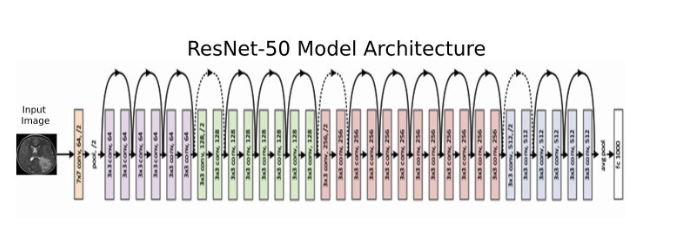

In [108]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [127]:
pretrained_model = ResNet50(input_shape=(224, 224, 3),
                                include_top=False,
                                weights='imagenet')


In [128]:
for layer in pretrained_model.layers:
    layer.trainable = True

In [132]:
inputs = pretrained_model.input

x = pretrained_model.output
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64,name='Feature_extractor', activation='relu')(x)
outputs = tf.keras.layers.Dense(17, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [134]:
from tensorflow.keras.optimizers import Adam, SGD
model.compile(Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [135]:
model.summary()

In [137]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard
import tensorflow as tf
import datetime, os
es = tf.keras.callbacks.EarlyStopping(patience=5)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            #verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [140]:
history = model.fit(train_generator, 
                    epochs=10,
                    validation_data=validation_generator, 
                    callbacks= [es, learning_rate_reduction],
                    steps_per_epoch=len(train_generator) //BATCH_SIZE,
                    validation_steps=len(validation_generator) //BATCH_SIZE  )

# **Model Performance**

In [141]:
model.save('resnet50.h5')

In [142]:
loss, accuracy = model.evaluate(validation_generator, verbose=2)


In [143]:
print(f"Model Loss is {loss:.2f} and Accuracy is {100*np.round(accuracy, 4)}%")


In [144]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

In [145]:
plot_loss_curves(history)

In [146]:
classes = list(train_generator.class_indices.keys())

In [147]:
def predict_val_image(index):
    predictions =  model.predict(val_images, verbose=0)[index]
    true_label = classes[val_labels[index].argmax()]
    predicted_label = classes[predictions.argmax()] 

    if(true_label== predicted_label):
        color = 'green'  
    else:
        color = 'red'

    plt.title(f"True : {true_label} Predicted: {predicted_label}", color=color)
    plt.imshow(val_images[index])
    plt.axis('off')
val_images, val_labels = validation_generator.next()
plt.figure(figsize=(20, 20))
for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    predict_val_image(i)

# **Prediction on test images which are not used for training and validation**

In [149]:
custom_dir = '../input/clothing-dataset-full/images_original'

In [150]:
custom_paths = []
for image in os.listdir(custom_dir):
        custom_paths.append(custom_dir+'/'+image)

In [152]:
def predict_random_image():
    path = random.choice(custom_paths)
    image = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    input_arr = input_arr.astype('float32') / 255.
    predictions = model.predict(input_arr, verbose=0)
    series = pd.Series(predictions[0], index=classes)
    predicted_classes = np.argsort(predictions)
    predictions.sort()
    plt.title(f"{classes[predicted_classes[0][-1]]} - {round(predictions[0][-1] * 100,2)}% \n{classes[predicted_classes[0][-2]]} - {round(predictions[0][-2] * 100,2)}% \n{classes[predicted_classes[0][-3]]} - {round(predictions[0][-2] * 100,3)}%")
    plt.imshow(image)
    plt.axis('off')

In [153]:
plt.figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    predict_random_image()